In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:99% !important;}</style>"))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from tqdm import tqdm
import os

#import tensorflow as tf
#import keras
from keras.layers import Dense, Dropout, Input, Flatten, Reshape, BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.callbacks import EarlyStopping, TensorBoard
from keras.datasets import mnist


Using TensorFlow backend.


# Generate Data

In [3]:
### Image dimensions
M = 28
MM = M*M
SIZE = (M,M)
N = 5000

In [4]:
### y1, y2 locations of start, end points of lines to connect
MU = M/2
SIGMA = 2

r = np.random.normal(MU, SIGMA, size=N*2).clip(0, M-1)
y1, y2 = r[:N], r[N:]

In [5]:
### Connect lines (analogue to digital) via discrete slope
# y = mx + b
# m = (y1-y0)/(x1-x0) = (y1-y0)/M
i = np.arange(M).reshape(-1,1)
y = (i*(y2-y1)/M + y1).astype(int)

Yh, Yv = [], []
for a in y.T:
    ### All lines are 1, all nonlines are 0
    #b = np.zeros(SIZE)
    #b[np.arange(M), a] = 1 
    ### All lines are >0, all nonlines are -1
    b = np.ones(SIZE) * -1
    b[np.arange(M), a] = np.abs(np.random.normal(0, SIGMA, size=M))
    Yh.append(b.T)
    Yv.append(b)
Yh = np.array(Yh)#, np.int8)
Yv = np.array(Yv)#, np.int8)

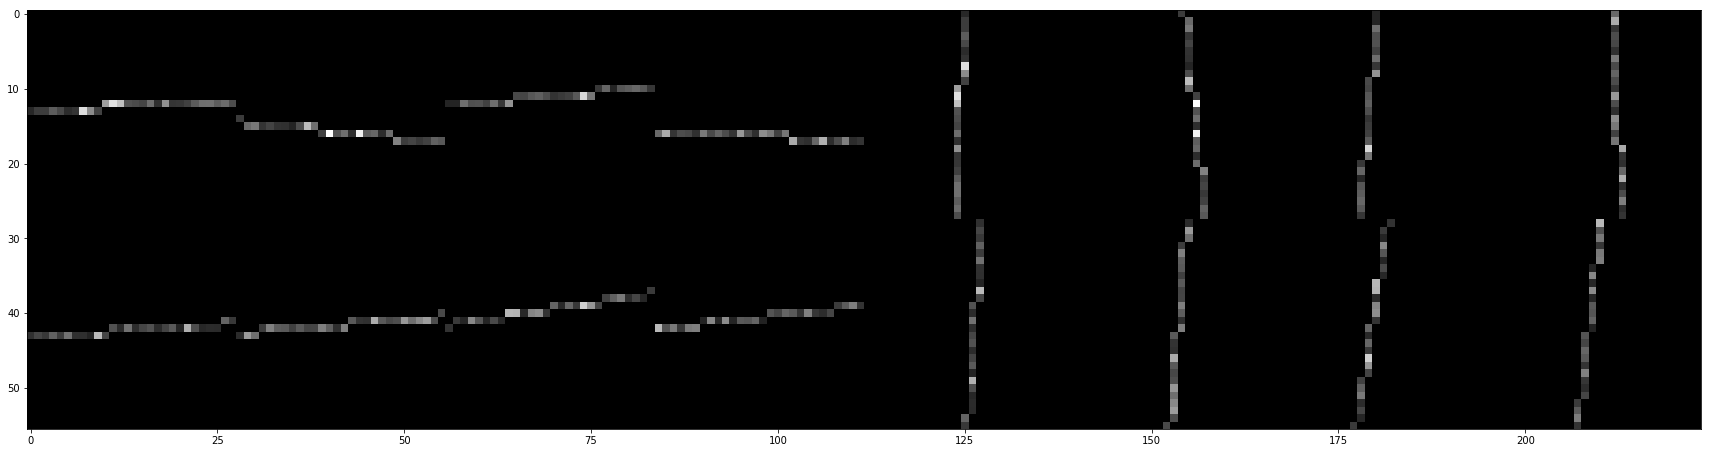

In [6]:
d = 4
r = 2
h = np.vstack([np.hstack(Yh[i*d:(i+1)*d]) for i in range(r)])
v = np.vstack([np.hstack(Yv[i*d:(i+1)*d]) for i in range(r)])

hv = np.hstack([h,v])
plt.figure(figsize=(30,10))
plt.imshow(hv, cmap='gray')
plt.show()

In [7]:
### Join horizontal, vertical lines for full dataset
#X = np.append(Yh, Yv, axis=0)
#X = Yh.copy()
X = Yv.copy()
np.random.shuffle(X)

In [8]:
### Save down as images
# for e, (h, v) in enumerate(zip(Yh,Yv)):
#     plt.imsave('Data/horizontal_{}.png'.format(e), h)
#     plt.imsave('Data/vertical_{}.png'.format(e), v)

#plt.imshow(plt.imread('Data/horizontal_4989.png')); plt.show()

In [9]:
# ### Reshape 2D images into 1D vector
# Xh_train = Yh.reshape(-1, M*M)
# Xv_train = Yv.reshape(-1, M*M)

# yh_train = np.zeros(Xh_train.shape[0])
# yv_train = np.ones(Xv_train.shape[0])

# Xhv_train = np.append(Xh_train, Xv_train, axis=0)
# yhv_train = np.append(yh_train, yv_train, axis=0)

# def unison_shuffled_copies(a, b):
#     assert len(a) == len(b)
#     p = np.random.permutation(len(a))
#     return a[p], b[p]

# X_train, y_train = unison_shuffled_copies(Xhv_train, yhv_train)

In [10]:
# ### Take random sample(s), reshape 1D vector back into 2D image to plot.
# for _ in range(1):
#     i = np.random.choice(range(len(y_train)))
#     plt.figure()
#     plt.imshow(X_train[i].reshape(M,M), cmap='gray')
#     plt.title('{}: {}'.format(i, 'V' if y_train[i] else 'H'))
#     plt.show()

# GAN

In [11]:
class DCGAN():
    '''https://arxiv.org/abs/1511.06434'''
    def __init__(self, X, model='model'):
        self.X = X
        self.nimgs = X.shape[0]
        try:
            self.img_n, self.img_nrows, self.img_ncols, self.img_nchannels = X.shape
        except ValueError:
            self.img_n, self.img_nrows, self.img_ncols = X.shape
            self.img_nchannels = 1
        self.img_shape = (self.img_nrows, self.img_ncols, self.img_nchannels)

        self.model = model
        self.initializer = RandomNormal(stddev=0.02, seed=0)
        self.optimizer = Adam(lr=0.0002, beta_1=0.5) 
        self.loss = 'binary_crossentropy'
    
        self.plot_dir = './dcgan/{}/plots/'.format(model)
        self.log_dir = './dcgan/{}/logs/'.format(model)
        self.model_dir = './dcgan/{}/models/'.format(model)
        
        if not os.path.exists(self.plot_dir): os.makedirs(self.plot_dir)
        if not os.path.exists(self.log_dir): os.makedirs(self.log_dir)
        if not os.path.exists(self.model_dir): os.makedirs(self.model_dir)
        
        s = 'Save paths:\n {}\n {}\n {}'
        print(s.format(self.plot_dir, self.log_dir, self.model_dir))

        self.GAN()
 
    def Generator(self):
        self.latent_dim = 100
        model = Sequential()
        model.add(Dense(128 * 7 * 7, input_dim=self.latent_dim, 
                        activation='relu', 
                        kernel_initializer=self.initializer,
                        bias_initializer=self.initializer))
        model.add(Reshape((7, 7, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding='same',
                         kernel_initializer=self.initializer,
                         bias_initializer=self.initializer))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation('relu'))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding='same',
                         kernel_initializer=self.initializer,
                         bias_initializer=self.initializer))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation('relu'))
        model.add(Conv2D(self.img_nchannels, kernel_size=3, padding='same',
                         kernel_initializer=self.initializer,
                         bias_initializer=self.initializer))
        model.add(Activation('tanh'))
        #print(model.summary())
        
        noise = Input(shape=(self.latent_dim,))
        img =  model(noise)
        
        return Model(noise, img) 

    
    def Discriminator(self):

        model = Sequential()
        model.add(Conv2D(32, input_shape=self.img_shape,
                         kernel_size=3, strides=2, 
                         padding="same", 
                         kernel_initializer=self.initializer,
                         bias_initializer=self.initializer))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same", 
                         kernel_initializer=self.initializer,
                         bias_initializer=self.initializer))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same", 
                         kernel_initializer=self.initializer,
                         bias_initializer=self.initializer))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same", 
                         kernel_initializer=self.initializer,
                         bias_initializer=self.initializer))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid', 
                        kernel_initializer=self.initializer,
                        bias_initializer=self.initializer))
        #print(model.summary())

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)
    

    def GAN(self):
        ### Build and compile the discriminator
        self.discriminator = self.Discriminator()
        self.discriminator.compile(loss=self.loss, optimizer=self.optimizer, 
                                   metrics=['accuracy'])#, 'mse'])

        ### Build the generator, gan
        # The generator takes noise as input and generates imgs
        # The discriminator takes generated images as input and determines validity
        # For the combined model we will only train the generator
        # The combined model (stacked generator and discriminator)
        # trains the generator to fool the discriminator
        self.generator = self.Generator()
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)
        self.discriminator.trainable = False
        validity = self.discriminator(img)
        self.gan = Model(z, validity)          
        self.gan.compile(loss=self.loss, optimizer=self.optimizer,
                         metrics=['acc'])#, 'mse'])
        
    
    
    def plot_imgs(self, epoch, dim1=1, dim2=4, figsize=(10,10), plot_dir='./plots/'):
        noise = self.Noise(dim1*dim2, self.latent_dim)
        g_imgs = self.generator.predict(noise)
        g_imgs = g_imgs.reshape(dim1*dim2, self.img_nrows, self.img_ncols)
        #print(g_imgs.shape, g_imgs.size)

        plt.figure(figsize=figsize)
        for e,i in enumerate(g_imgs):
            #print(e, dim1, dim2, i.shape, i.size)
            plt.subplot(dim1, dim2, e+1)
            plt.imshow(i, cmap='gray')
            plt.axis('off')
        plt.savefig('{}{}.png'.format(plot_dir, epoch))
        plt.show(block=False)  
   
    
    def Noise(self, dim1, dim2, mu=0, sigma=1):
        return np.random.normal(mu, sigma, (dim1, dim2))
    
    
    def normalize(self, x, alpha=-1, beta=1):
        '''cv.normalize(x, None, -1, 1, cv.NORM_MINMAX) was not normalizing below 0.
        Had to do it myself.'''
        a = x.min()
        b = x.max()
        return (x-a)/(b-a)*(beta-alpha) + alpha

    
    def named_logs(self, model, logs, prefix=False):
        mmn = model.metrics_names
        if prefix: 
            mmn = [prefix+i for i in mmn]
        result = {}
        for l in zip(mmn, logs):
            result[l[0]] = l[1]
        return result

    
    def train(self, epochs, batch_size=128, save_interval=50):
        
        #earlystopping = EarlyStopping(monitor='val_history', mode='min', patience=5, verbose=1)
        
        tensorboard = TensorBoard(log_dir=self.log_dir, histogram_freq=0, 
                                  batch_size=batch_size, 
                                  write_graph=True, write_grads=True)
        tensorboard.set_model(self.discriminator)
        tensorboard.set_model(self.generator)

        self.X = self.normalize(self.X)
        self.X = np.expand_dims(self.X, axis=3)

        # Adversarial ground truths
        # https://medium.com/@utk.is.here/keep-calm-and-train-a-gan-pitfalls-and-tips-on-training-generative-adversarial-networks-edd529764aa9
        # "If you are using Real Images = 1 and Generated Images = 0, 
        # it helps to have it the other way around. As we will see later, 
        # this helps with the gradient flow in the early iterations and 
        # helps get things moving."
        valid = np.zeros((batch_size, 1))
        fake = np.ones((batch_size, 1))
        #valid = np.random.uniform(0, 0.1, (batch_size,1))
        #fake = np.random.uniform(0.9, 1, (batch_size,1))
        #valid = np.zeros((batch_size, 1)) * np.random.uniform(0, 0.1, 1)
        #fake = np.ones((batch_size, 1)) * np.random.uniform(0.9, 1, 1)

        j = 0
        for epoch in range(epochs+1):

            # Select a random batch of images
            i = np.random.randint(0, self.img_n, batch_size)
            imgs = self.X[i]
            noise = self.Noise(batch_size, self.latent_dim)
            gen_imgs = self.generator.predict(noise)
            
            # Train the discriminator (real classified as ones and generated as zeros)
            #self.discriminator.trainable = True
            d_history_real = self.discriminator.train_on_batch(imgs, valid)
            d_history_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_history = 0.5 * np.add(d_history_real, d_history_fake)

            # Train the generator (wants discriminator to mistake images as real)            
            g_history = self.gan.train_on_batch(noise, valid)

            # Plot the progress
            # If at save interval => save generated image samples
            tensorboard.on_epoch_end(j, self.named_logs(self.discriminator, d_history, prefix='d_both_'))
            tensorboard.on_epoch_end(j, self.named_logs(self.discriminator, d_history_real, prefix='d_real_'))
            tensorboard.on_epoch_end(j, self.named_logs(self.discriminator, d_history_fake, prefix='d_fake_'))
            tensorboard.on_epoch_end(j, self.named_logs(self.gan, g_history, prefix='g_'))

            s = 'Epoch {0}/{1}  ||  D acc: {2:.2f}, loss: {3:.2f}  | G loss: {4:.2f}'
            print(s.format(epoch, epochs, d_history[1], d_history[0], g_history[0]))

            if epoch % save_interval == 0:
                self.plot_imgs(epoch, plot_dir=self.plot_dir)
                self.discriminator.save(self.model_dir+'discriminator.h5')
                self.generator.save(self.model_dir+'generator.h5')
                self.gan.save(self.model_dir+'gan.h5')
            
            j += 1

            #if g_history[1] == 1.:
            #    break

In [12]:
# # Load the dataset
# (X, _), (_, _) = mnist.load_data()
# plt.imshow(X[0], cmap='gray'); plt.show()

In [13]:
dcgan = DCGAN(X, 'model1_v')

Save paths:
 ./dcgan/model1_v/plots/
 ./dcgan/model1_v/logs/
 ./dcgan/model1_v/models/


Instructions for updating:
Use the retry module or similar alternatives.


/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 0/500  ||  D acc: 0.11, loss: 1.33  | G loss: 0.56


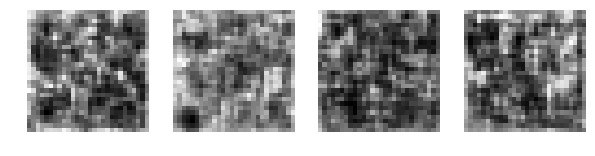

Epoch 1/500  ||  D acc: 0.70, loss: 0.60  | G loss: 1.53
Epoch 2/500  ||  D acc: 0.75, loss: 0.51  | G loss: 2.42
Epoch 3/500  ||  D acc: 0.69, loss: 0.61  | G loss: 2.99
Epoch 4/500  ||  D acc: 0.80, loss: 0.45  | G loss: 3.33
Epoch 5/500  ||  D acc: 0.66, loss: 0.66  | G loss: 3.19
Epoch 6/500  ||  D acc: 0.80, loss: 0.53  | G loss: 2.71
Epoch 7/500  ||  D acc: 0.78, loss: 0.49  | G loss: 3.01
Epoch 8/500  ||  D acc: 0.81, loss: 0.44  | G loss: 2.30
Epoch 9/500  ||  D acc: 0.83, loss: 0.37  | G loss: 2.08
Epoch 10/500  ||  D acc: 0.97, loss: 0.16  | G loss: 1.30
Epoch 11/500  ||  D acc: 0.98, loss: 0.17  | G loss: 1.30
Epoch 12/500  ||  D acc: 1.00, loss: 0.12  | G loss: 1.25
Epoch 13/500  ||  D acc: 0.98, loss: 0.17  | G loss: 1.09
Epoch 14/500  ||  D acc: 0.97, loss: 0.15  | G loss: 1.00
Epoch 15/500  ||  D acc: 0.89, loss: 0.36  | G loss: 3.50
Epoch 16/500  ||  D acc: 0.12, loss: 2.02  | G loss: 1.92
Epoch 17/500  ||  D acc: 0.61, loss: 0.62  | G loss: 2.93
Epoch 18/500  ||  D acc

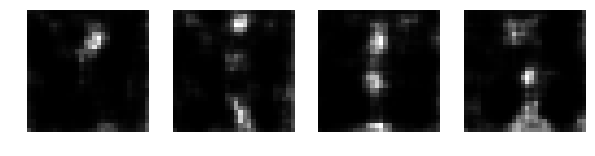

Epoch 51/500  ||  D acc: 0.27, loss: 1.07  | G loss: 0.98
Epoch 52/500  ||  D acc: 0.33, loss: 0.95  | G loss: 1.46
Epoch 53/500  ||  D acc: 0.25, loss: 1.05  | G loss: 1.15
Epoch 54/500  ||  D acc: 0.50, loss: 0.78  | G loss: 1.56
Epoch 55/500  ||  D acc: 0.45, loss: 0.84  | G loss: 1.37
Epoch 56/500  ||  D acc: 0.56, loss: 0.77  | G loss: 1.46
Epoch 57/500  ||  D acc: 0.44, loss: 0.78  | G loss: 1.43
Epoch 58/500  ||  D acc: 0.50, loss: 0.78  | G loss: 1.62
Epoch 59/500  ||  D acc: 0.42, loss: 0.94  | G loss: 1.04
Epoch 60/500  ||  D acc: 0.44, loss: 0.83  | G loss: 1.35
Epoch 61/500  ||  D acc: 0.31, loss: 1.02  | G loss: 1.45
Epoch 62/500  ||  D acc: 0.25, loss: 1.02  | G loss: 1.12
Epoch 63/500  ||  D acc: 0.34, loss: 0.90  | G loss: 1.14
Epoch 64/500  ||  D acc: 0.41, loss: 0.84  | G loss: 1.16
Epoch 65/500  ||  D acc: 0.33, loss: 0.96  | G loss: 0.89
Epoch 66/500  ||  D acc: 0.30, loss: 1.03  | G loss: 1.18
Epoch 67/500  ||  D acc: 0.39, loss: 0.88  | G loss: 1.27
Epoch 68/500  

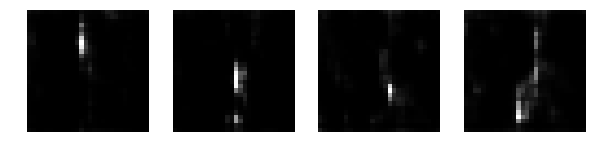

Epoch 101/500  ||  D acc: 0.48, loss: 0.85  | G loss: 1.63
Epoch 102/500  ||  D acc: 0.52, loss: 0.84  | G loss: 1.21
Epoch 103/500  ||  D acc: 0.38, loss: 0.90  | G loss: 1.25
Epoch 104/500  ||  D acc: 0.53, loss: 0.76  | G loss: 1.40
Epoch 105/500  ||  D acc: 0.66, loss: 0.65  | G loss: 1.36
Epoch 106/500  ||  D acc: 0.61, loss: 0.79  | G loss: 1.71
Epoch 107/500  ||  D acc: 0.44, loss: 0.93  | G loss: 1.39
Epoch 108/500  ||  D acc: 0.48, loss: 0.81  | G loss: 1.53
Epoch 109/500  ||  D acc: 0.45, loss: 0.91  | G loss: 1.68
Epoch 110/500  ||  D acc: 0.61, loss: 0.75  | G loss: 1.74
Epoch 111/500  ||  D acc: 0.61, loss: 0.76  | G loss: 1.55
Epoch 112/500  ||  D acc: 0.50, loss: 0.87  | G loss: 1.37
Epoch 113/500  ||  D acc: 0.27, loss: 1.09  | G loss: 1.26
Epoch 114/500  ||  D acc: 0.33, loss: 1.11  | G loss: 1.20
Epoch 115/500  ||  D acc: 0.27, loss: 1.17  | G loss: 1.21
Epoch 116/500  ||  D acc: 0.33, loss: 1.05  | G loss: 1.06
Epoch 117/500  ||  D acc: 0.22, loss: 1.09  | G loss: 1.

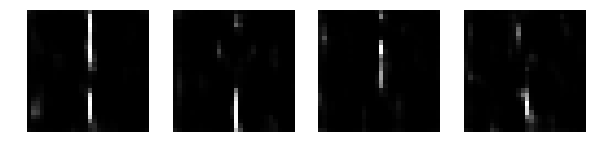

Epoch 151/500  ||  D acc: 0.34, loss: 0.95  | G loss: 1.39
Epoch 152/500  ||  D acc: 0.38, loss: 0.92  | G loss: 1.21
Epoch 153/500  ||  D acc: 0.52, loss: 0.82  | G loss: 1.35
Epoch 154/500  ||  D acc: 0.56, loss: 0.79  | G loss: 1.32
Epoch 155/500  ||  D acc: 0.66, loss: 0.63  | G loss: 1.21
Epoch 156/500  ||  D acc: 0.53, loss: 0.79  | G loss: 1.25
Epoch 157/500  ||  D acc: 0.59, loss: 0.67  | G loss: 1.35
Epoch 158/500  ||  D acc: 0.72, loss: 0.60  | G loss: 1.22
Epoch 159/500  ||  D acc: 0.61, loss: 0.65  | G loss: 1.17
Epoch 160/500  ||  D acc: 0.62, loss: 0.72  | G loss: 1.28
Epoch 161/500  ||  D acc: 0.42, loss: 0.79  | G loss: 1.12
Epoch 162/500  ||  D acc: 0.61, loss: 0.72  | G loss: 1.30
Epoch 163/500  ||  D acc: 0.53, loss: 0.75  | G loss: 1.33
Epoch 164/500  ||  D acc: 0.59, loss: 0.75  | G loss: 1.47
Epoch 165/500  ||  D acc: 0.48, loss: 0.84  | G loss: 1.18
Epoch 166/500  ||  D acc: 0.39, loss: 0.86  | G loss: 1.12
Epoch 167/500  ||  D acc: 0.56, loss: 0.77  | G loss: 1.

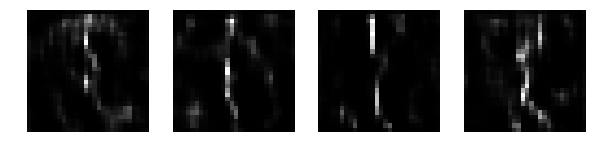

Epoch 201/500  ||  D acc: 0.47, loss: 0.81  | G loss: 1.08
Epoch 202/500  ||  D acc: 0.47, loss: 0.78  | G loss: 1.20
Epoch 203/500  ||  D acc: 0.25, loss: 0.98  | G loss: 1.23
Epoch 204/500  ||  D acc: 0.45, loss: 0.84  | G loss: 1.09
Epoch 205/500  ||  D acc: 0.45, loss: 0.84  | G loss: 1.08
Epoch 206/500  ||  D acc: 0.48, loss: 0.77  | G loss: 1.16
Epoch 207/500  ||  D acc: 0.48, loss: 0.77  | G loss: 1.20
Epoch 208/500  ||  D acc: 0.38, loss: 0.81  | G loss: 1.25
Epoch 209/500  ||  D acc: 0.64, loss: 0.68  | G loss: 1.09
Epoch 210/500  ||  D acc: 0.45, loss: 0.77  | G loss: 1.11
Epoch 211/500  ||  D acc: 0.62, loss: 0.68  | G loss: 1.21
Epoch 212/500  ||  D acc: 0.36, loss: 0.84  | G loss: 1.32
Epoch 213/500  ||  D acc: 0.58, loss: 0.73  | G loss: 1.40
Epoch 214/500  ||  D acc: 0.42, loss: 0.83  | G loss: 1.43
Epoch 215/500  ||  D acc: 0.59, loss: 0.68  | G loss: 1.11
Epoch 216/500  ||  D acc: 0.45, loss: 0.80  | G loss: 1.19
Epoch 217/500  ||  D acc: 0.42, loss: 0.81  | G loss: 1.

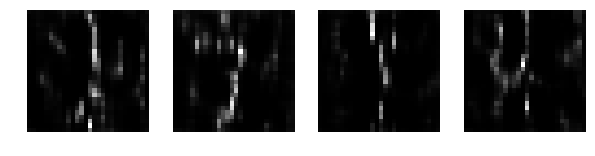

Epoch 251/500  ||  D acc: 0.64, loss: 0.68  | G loss: 1.02
Epoch 252/500  ||  D acc: 0.56, loss: 0.76  | G loss: 1.18
Epoch 253/500  ||  D acc: 0.47, loss: 0.79  | G loss: 1.31
Epoch 254/500  ||  D acc: 0.59, loss: 0.74  | G loss: 1.20
Epoch 255/500  ||  D acc: 0.48, loss: 0.80  | G loss: 1.15
Epoch 256/500  ||  D acc: 0.50, loss: 0.79  | G loss: 1.13
Epoch 257/500  ||  D acc: 0.50, loss: 0.74  | G loss: 1.25
Epoch 258/500  ||  D acc: 0.52, loss: 0.71  | G loss: 1.02
Epoch 259/500  ||  D acc: 0.48, loss: 0.82  | G loss: 1.15
Epoch 260/500  ||  D acc: 0.55, loss: 0.78  | G loss: 1.13
Epoch 261/500  ||  D acc: 0.47, loss: 0.80  | G loss: 1.10
Epoch 262/500  ||  D acc: 0.28, loss: 0.92  | G loss: 0.93
Epoch 263/500  ||  D acc: 0.45, loss: 0.79  | G loss: 1.34
Epoch 264/500  ||  D acc: 0.45, loss: 0.84  | G loss: 1.31
Epoch 265/500  ||  D acc: 0.42, loss: 0.84  | G loss: 1.10
Epoch 266/500  ||  D acc: 0.44, loss: 0.80  | G loss: 1.01
Epoch 267/500  ||  D acc: 0.59, loss: 0.69  | G loss: 1.

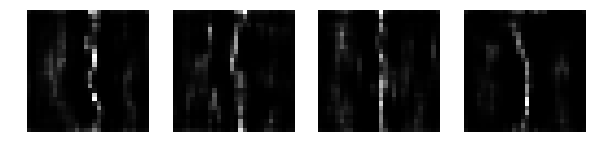

Epoch 301/500  ||  D acc: 0.41, loss: 0.79  | G loss: 1.09
Epoch 302/500  ||  D acc: 0.36, loss: 0.81  | G loss: 1.15
Epoch 303/500  ||  D acc: 0.47, loss: 0.76  | G loss: 1.36
Epoch 304/500  ||  D acc: 0.55, loss: 0.72  | G loss: 1.30
Epoch 305/500  ||  D acc: 0.31, loss: 0.90  | G loss: 1.20
Epoch 306/500  ||  D acc: 0.52, loss: 0.75  | G loss: 1.01
Epoch 307/500  ||  D acc: 0.45, loss: 0.83  | G loss: 1.18
Epoch 308/500  ||  D acc: 0.50, loss: 0.72  | G loss: 1.16
Epoch 309/500  ||  D acc: 0.36, loss: 0.79  | G loss: 1.04
Epoch 310/500  ||  D acc: 0.45, loss: 0.83  | G loss: 1.23
Epoch 311/500  ||  D acc: 0.45, loss: 0.77  | G loss: 1.30
Epoch 312/500  ||  D acc: 0.50, loss: 0.72  | G loss: 1.26
Epoch 313/500  ||  D acc: 0.55, loss: 0.74  | G loss: 1.37
Epoch 314/500  ||  D acc: 0.62, loss: 0.69  | G loss: 1.05
Epoch 315/500  ||  D acc: 0.59, loss: 0.76  | G loss: 1.15
Epoch 316/500  ||  D acc: 0.59, loss: 0.68  | G loss: 1.00
Epoch 317/500  ||  D acc: 0.53, loss: 0.72  | G loss: 1.

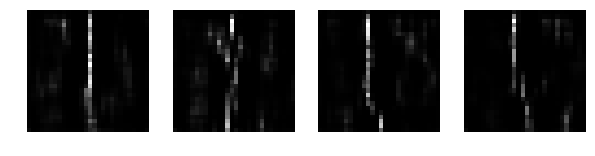

Epoch 351/500  ||  D acc: 0.50, loss: 0.79  | G loss: 1.00
Epoch 352/500  ||  D acc: 0.44, loss: 0.77  | G loss: 1.31
Epoch 353/500  ||  D acc: 0.38, loss: 0.97  | G loss: 0.90
Epoch 354/500  ||  D acc: 0.50, loss: 0.77  | G loss: 0.93
Epoch 355/500  ||  D acc: 0.59, loss: 0.69  | G loss: 1.00
Epoch 356/500  ||  D acc: 0.52, loss: 0.76  | G loss: 0.96
Epoch 357/500  ||  D acc: 0.45, loss: 0.79  | G loss: 1.01
Epoch 358/500  ||  D acc: 0.45, loss: 0.78  | G loss: 1.12
Epoch 359/500  ||  D acc: 0.47, loss: 0.76  | G loss: 1.28
Epoch 360/500  ||  D acc: 0.38, loss: 0.87  | G loss: 1.15
Epoch 361/500  ||  D acc: 0.55, loss: 0.76  | G loss: 1.03
Epoch 362/500  ||  D acc: 0.39, loss: 0.80  | G loss: 0.88
Epoch 363/500  ||  D acc: 0.55, loss: 0.77  | G loss: 0.98
Epoch 364/500  ||  D acc: 0.45, loss: 0.79  | G loss: 0.96
Epoch 365/500  ||  D acc: 0.42, loss: 0.83  | G loss: 0.96
Epoch 366/500  ||  D acc: 0.30, loss: 0.97  | G loss: 0.92
Epoch 367/500  ||  D acc: 0.61, loss: 0.68  | G loss: 1.

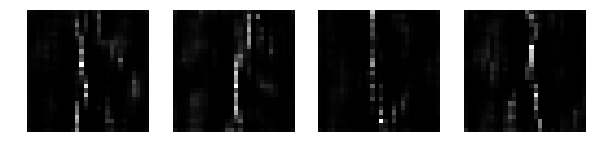

Epoch 401/500  ||  D acc: 0.66, loss: 0.63  | G loss: 1.15
Epoch 402/500  ||  D acc: 0.56, loss: 0.72  | G loss: 1.02
Epoch 403/500  ||  D acc: 0.55, loss: 0.73  | G loss: 1.04
Epoch 404/500  ||  D acc: 0.58, loss: 0.67  | G loss: 1.19
Epoch 405/500  ||  D acc: 0.52, loss: 0.77  | G loss: 1.23
Epoch 406/500  ||  D acc: 0.44, loss: 0.78  | G loss: 1.04
Epoch 407/500  ||  D acc: 0.50, loss: 0.74  | G loss: 1.11
Epoch 408/500  ||  D acc: 0.41, loss: 0.84  | G loss: 1.06
Epoch 409/500  ||  D acc: 0.50, loss: 0.72  | G loss: 1.16
Epoch 410/500  ||  D acc: 0.41, loss: 0.82  | G loss: 1.06
Epoch 411/500  ||  D acc: 0.47, loss: 0.75  | G loss: 0.97
Epoch 412/500  ||  D acc: 0.45, loss: 0.78  | G loss: 1.06
Epoch 413/500  ||  D acc: 0.47, loss: 0.77  | G loss: 1.10
Epoch 414/500  ||  D acc: 0.56, loss: 0.67  | G loss: 1.19
Epoch 415/500  ||  D acc: 0.17, loss: 0.93  | G loss: 0.95
Epoch 416/500  ||  D acc: 0.45, loss: 0.74  | G loss: 1.02
Epoch 417/500  ||  D acc: 0.38, loss: 0.80  | G loss: 1.

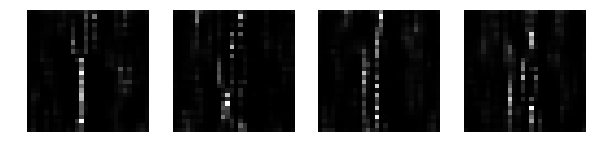

Epoch 451/500  ||  D acc: 0.53, loss: 0.76  | G loss: 1.19
Epoch 452/500  ||  D acc: 0.38, loss: 0.85  | G loss: 0.91
Epoch 453/500  ||  D acc: 0.45, loss: 0.80  | G loss: 0.96
Epoch 454/500  ||  D acc: 0.55, loss: 0.74  | G loss: 1.05
Epoch 455/500  ||  D acc: 0.42, loss: 0.82  | G loss: 0.95
Epoch 456/500  ||  D acc: 0.41, loss: 0.85  | G loss: 1.00
Epoch 457/500  ||  D acc: 0.48, loss: 0.75  | G loss: 0.89
Epoch 458/500  ||  D acc: 0.52, loss: 0.74  | G loss: 0.91
Epoch 459/500  ||  D acc: 0.50, loss: 0.77  | G loss: 0.94
Epoch 460/500  ||  D acc: 0.48, loss: 0.71  | G loss: 0.93
Epoch 461/500  ||  D acc: 0.27, loss: 0.96  | G loss: 0.92
Epoch 462/500  ||  D acc: 0.44, loss: 0.82  | G loss: 0.99
Epoch 463/500  ||  D acc: 0.56, loss: 0.68  | G loss: 1.13
Epoch 464/500  ||  D acc: 0.45, loss: 0.73  | G loss: 1.14
Epoch 465/500  ||  D acc: 0.50, loss: 0.74  | G loss: 0.98
Epoch 466/500  ||  D acc: 0.50, loss: 0.76  | G loss: 1.02
Epoch 467/500  ||  D acc: 0.47, loss: 0.71  | G loss: 0.

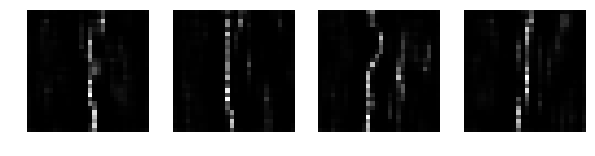

In [14]:
dcgan.train(epochs=500, batch_size=32, save_interval=50)

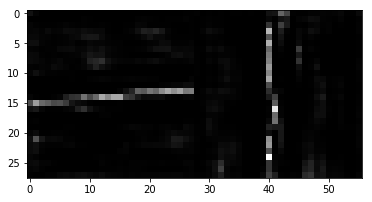

In [41]:
from keras.models import load_model
model1_h_g = load_model('./dcgan/model1_h/models/generator.h5')
model1_v_g = load_model('./dcgan/model1_v/models/generator.h5')

def Noise(dim1, dim2, mu=0, sigma=1):
    return np.random.normal(mu, sigma, (dim1, dim2))

noise = Noise(1, 100)
img_h = model1_h_g.predict(noise).reshape(28,28)
img_v = model1_v_g.predict(noise).reshape(28,28)

plt.imshow(np.hstack([img_h, img_v]), cmap='gray')
plt.show()